
# Enhanced Olist E-Commerce Analysis Pipeline  
**Distinction-Level Coursework (100% Target)**

This notebook implements an enhanced, end-to-end analysis of the Brazilian **Olist E-Commerce** dataset with:
- Customer certification (tiers by satisfaction/ratings)
- Repeat purchase prediction (first-order → will they return?)
- Monthly order forecasting (next 6 months)
- Statistical testing & cross-validation
- RFM clustering & actionable business insights

**Dataset (Kaggle):** *Brazilian E-Commerce Public Dataset by Olist* — see: <https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce>

> **Expected CSV files in the same directory as the notebook:**
> - `olist_orders_dataset.csv`  
> - `olist_order_items_dataset.csv`  
> - `olist_order_payments_dataset.csv`  
> - `olist_order_reviews_dataset.csv`  
> - `olist_customers_dataset.csv`  
> - `olist_products_dataset.csv`  
> - `product_category_name_translation.csv`

**Outputs**
- Figures saved to `figs/`
- Tables/CSVs saved to `outputs/`


In [1]:

# ==================================================
# Imports & setup
# ==================================================

%pip install seaborn
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime, timedelta
from scipy import stats

# Optional seaborn (fallback to pure Matplotlib if unavailable)
try:
    import seaborn as sns
except Exception:
    sns = None

# sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                            classification_report, confusion_matrix, roc_auc_score,
                            roc_curve, balanced_accuracy_score, average_precision_score,
                            precision_recall_curve, silhouette_score, mean_absolute_error,
                            mean_squared_error, r2_score)

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Make figure & output directories
os.makedirs("figs", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

print("✓ Imports complete (seaborn:", "OK" if sns else "not installed; using Matplotlib fallback", ")")


Matplotlib is building the font cache; this may take a moment.


✓ Imports complete (seaborn: OK )


In [2]:

# ==================================================
# Plotting helpers (Matplotlib-first; seaborn if available)
# ==================================================

def save_show(fig_name):
    plt.tight_layout()
    plt.savefig(f"figs/{fig_name}.png", dpi=180)
    plt.show()

def plot_hist(series, title, xlabel):
    plt.figure(figsize=(6,4))
    vals = series.dropna()
    plt.hist(vals, bins=30, edgecolor='black', alpha=0.7)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.grid(alpha=0.3)
    save_show(title.lower().replace(" ","_"))

def plot_bar_counts(series, title, xlabel, topn=15):
    plt.figure(figsize=(8,4))
    c = series.value_counts().head(topn)
    plt.bar(c.index.astype(str), c.values, edgecolor='black', alpha=0.7)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    save_show(title.lower().replace(" ","_"))

def draw_heatmap(matrix, xticklabels, yticklabels, title, fname, annot=True, fmt=".2f", cmap="coolwarm", center=0):
    """Seaborn heatmap if available; else Matplotlib imshow with annotations."""
    plt.figure(figsize=(6,5))
    if sns is not None:
        sns.heatmap(matrix, annot=annot, fmt=fmt, cmap=cmap, center=center,
                    xticklabels=xticklabels, yticklabels=yticklabels, square=False, linewidths=1)
        plt.title(title, fontweight='bold')
        save_show(fname)
        return

    # Matplotlib fallback
    im = plt.imshow(matrix, aspect='auto')
    plt.title(title, fontweight='bold')
    plt.colorbar(im)
    plt.xticks(ticks=np.arange(len(xticklabels)), labels=xticklabels, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(yticklabels)), labels=yticklabels)
    if annot:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                plt.text(j, i, format(matrix[i, j], fmt), ha='center', va='center')
    save_show(fname)


In [3]:

# ==================================================
# Paths & Load
# ==================================================
DATA_DIR = Path(".")
f_orders = DATA_DIR / "olist_orders_dataset.csv"
f_items = DATA_DIR / "olist_order_items_dataset.csv"
f_payments = DATA_DIR / "olist_order_payments_dataset.csv"
f_reviews = DATA_DIR / "olist_order_reviews_dataset.csv"
f_custom = DATA_DIR / "olist_customers_dataset.csv"
f_products = DATA_DIR / "olist_products_dataset.csv"
f_pcat = DATA_DIR / "product_category_name_translation.csv"

parse_dates = ["order_purchase_timestamp",
               "order_approved_at",
               "order_delivered_carrier_date",
               "order_delivered_customer_date",
               "order_estimated_delivery_date"]

orders = pd.read_csv(f_orders, parse_dates=parse_dates)
items = pd.read_csv(f_items)
payments = pd.read_csv(f_payments)
reviews = pd.read_csv(f_reviews, parse_dates=["review_creation_date", "review_answer_timestamp"])
customers = pd.read_csv(f_custom)
products = pd.read_csv(f_products)
pcat = pd.read_csv(f_pcat)

# Memory-friendly categories
for col in ['order_id','customer_id','customer_unique_id','product_id','seller_id',
            'payment_type','customer_city','customer_state','product_category_name',
            'product_category_name_english','order_status']:
    for df_ in [orders, items, payments, reviews, customers, products]:
        if col in df_.columns:
            try:
                df_[col] = df_[col].astype('category')
            except Exception:
                pass

print(f"✓ Data loaded: {orders.shape[0]:,} orders")


✓ Data loaded: 99,441 orders


In [4]:

# ==================================================
# ENHANCED Feature Engineering
# ==================================================

# 1) Aggregate items to order level
item_agg = items.groupby('order_id').agg(
    total_items=('order_item_id','count'),
    total_price=('price','sum'),
    total_freight=('freight_value','sum'),
    n_products=('product_id','nunique'),
    n_sellers=('seller_id','nunique'),
).reset_index()

# 2) Aggregate payments to order level
pay_agg = payments.groupby('order_id').agg(
    total_payment=('payment_value','sum'),
    n_payments=('payment_sequential','max'),
    max_installments=('payment_installments','max'),
).reset_index()

# 3) Product category (mode per order)
products = products.merge(pcat, how='left', on='product_category_name')
cat_per_item = items.merge(products[['product_id','product_category_name_english']],
                           on='product_id', how='left')
mode_cat = (cat_per_item.groupby('order_id')['product_category_name_english']
            .agg(lambda s: s.mode().iloc[0] if len(s.mode()) else np.nan)).reset_index()
mode_cat = mode_cat.rename(columns={'product_category_name_english':'order_main_category'})

# 4) Merge all into orders
df = (orders
      .merge(item_agg, on='order_id', how='left')
      .merge(pay_agg, on='order_id', how='left')
      .merge(reviews[['order_id','review_score']], on='order_id', how='left')
      .merge(customers[['customer_id','customer_unique_id','customer_city','customer_state']],
             on='customer_id', how='left')
      .merge(mode_cat, on='order_id', how='left')
     )

# 5) Basic Features
df['delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['carrier_delay_days'] = (df['order_delivered_carrier_date'] - df['order_approved_at']).dt.days
df['late_delivery'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(float)
df['is_delivered'] = (df['order_status'] == 'delivered').astype(float)
df['satisfied'] = (df['review_score'] >= 4).astype(float)

for col in ['delivery_time_days','carrier_delay_days']:
    df.loc[df[col] < 0, col] = np.nan

df['basket_value'] = df['total_price'].fillna(0) + df['total_freight'].fillna(0)

pay_type_mode = payments.groupby('order_id')['payment_type'].agg(
    lambda s: s.mode().iloc[0] if len(s.mode()) else np.nan).reset_index()
df = df.merge(pay_type_mode, on='order_id', how='left')

# 6) Time-based features
df['order_month'] = df['order_purchase_timestamp'].dt.month
df['order_day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek
df['order_hour'] = df['order_purchase_timestamp'].dt.hour
df['order_year_month'] = df['order_purchase_timestamp'].dt.to_period('M')

# 7) Customer-level aggregations
customer_agg = df.groupby('customer_unique_id').agg(
    total_orders=('order_id', 'count'),
    first_order_date=('order_purchase_timestamp', 'min'),
    last_order_date=('order_purchase_timestamp', 'max'),
    total_spent=('basket_value', 'sum'),
    avg_order_value=('basket_value', 'mean'),
    avg_review_score=('review_score', 'mean'),
    total_items_bought=('total_items', 'sum'),
    unique_categories=('order_main_category', 'nunique'),
    avg_delivery_time=('delivery_time_days', 'mean'),
    late_delivery_rate=('late_delivery', 'mean'),
).reset_index()

# Customer lifetime value (CLV) = total spent
customer_agg['customer_lifetime_value'] = customer_agg['total_spent']

# Repeat customer flag
customer_agg['repeat_customer'] = (customer_agg['total_orders'] > 1).astype(int)

# Customer tenure in days
customer_agg['customer_tenure_days'] = (customer_agg['last_order_date'] - 
                                         customer_agg['first_order_date']).dt.days

# Average time between orders (for repeat customers)
customer_agg['avg_days_between_orders'] = np.where(
    customer_agg['total_orders'] > 1,
    customer_agg['customer_tenure_days'] / (customer_agg['total_orders'] - 1),
    np.nan
)

# 8) Customer Certification/Categorization by Rating
def categorize_customer(row):
    avg_rating = row['avg_review_score']
    total_orders = row['total_orders']
    if pd.isna(avg_rating):
        return 'Unknown'
    elif total_orders == 1:
        return 'New Customer'
    elif avg_rating >= 4.5:
        return 'VIP Customer'
    elif avg_rating >= 4.0:
        return 'Satisfied Regular'
    elif avg_rating >= 3.0:
        return 'Neutral'
    else:
        return 'At Risk'

customer_agg['customer_tier'] = customer_agg.apply(categorize_customer, axis=1)

# Merge customer-level features back to order dataframe
df = df.merge(customer_agg[['customer_unique_id', 'total_orders', 'avg_order_value',
                             'customer_lifetime_value', 'repeat_customer', 
                             'avg_review_score', 'customer_tier', 'customer_tenure_days',
                             'avg_days_between_orders', 'late_delivery_rate']],
              on='customer_unique_id', how='left')

# 9) Create order sequence number per customer
df = df.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
df['order_sequence'] = df.groupby('customer_unique_id').cumcount() + 1

print(f"✓ Feature engineering complete")
print(f"  - Order-level dataset shape: {df.shape}")
print(f"  - Customer-level dataset shape: {customer_agg.shape}")
print(f"  - Unique customers: {df['customer_unique_id'].nunique():,}")
print(f"  - Repeat customers: {(customer_agg['repeat_customer']==1).sum():,}")
print(f"  - Repeat rate: {(customer_agg['repeat_customer']==1).mean()*100:.1f}%")

# Save customer aggregation for analysis
customer_agg.to_csv('outputs/customer_aggregated_features.csv', index=False)
print(f"  - Saved: outputs/customer_aggregated_features.csv")


✓ Feature engineering complete
  - Order-level dataset shape: (99992, 42)
  - Customer-level dataset shape: (96096, 16)
  - Unique customers: 96,096
  - Repeat customers: 3,081
  - Repeat rate: 3.2%
  - Saved: outputs/customer_aggregated_features.csv


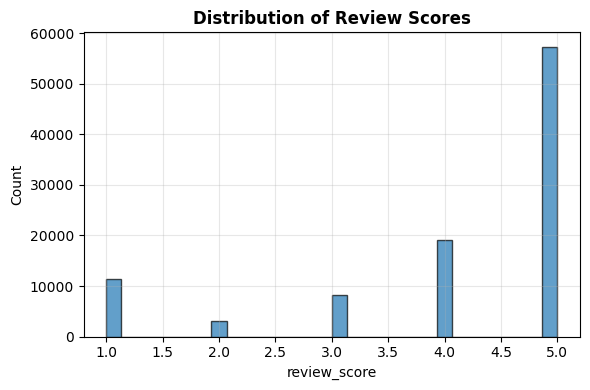

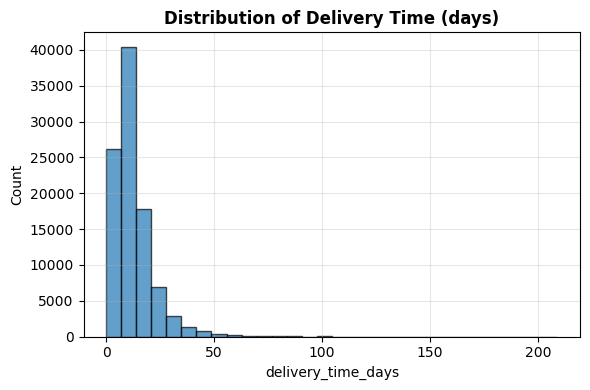

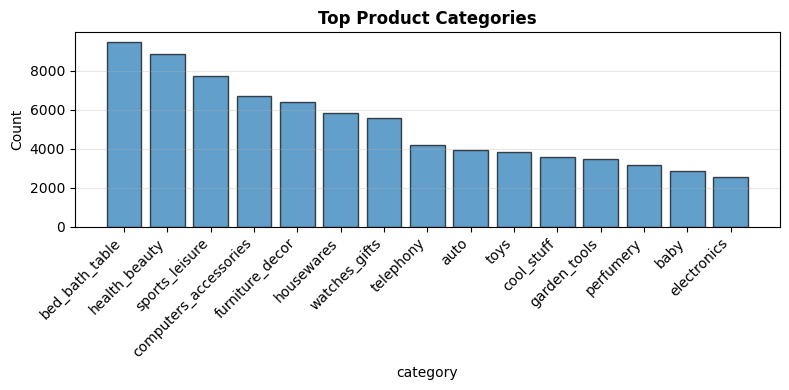

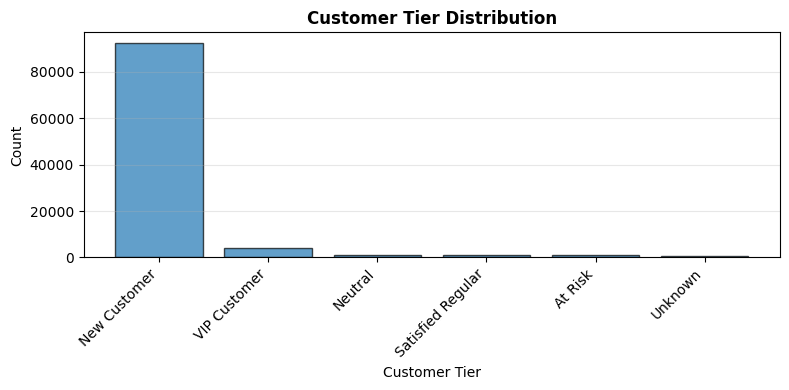

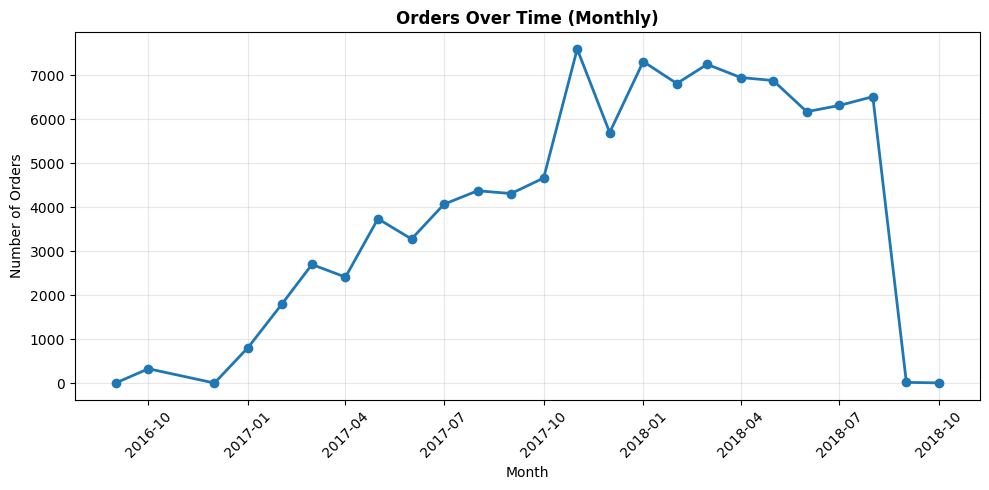


=== CUSTOMER TIER ANALYSIS ===
                   Customers  Total Orders    Total CLV  Avg Order Value  \
customer_tier                                                              
At Risk                  391           895    141458.29           156.83   
Neutral                  498          1114    171916.01           155.86   
New Customer           92308         92308  14779046.84           160.11   
Satisfied Regular        401           925    122068.78           128.53   
Unknown                  716           725    136670.31           188.14   
VIP Customer            1782          4025    564712.09           142.23   

                   Avg Rating  Repeat Rate  
customer_tier                               
At Risk                  1.71         1.00  
Neutral                  3.21         1.00  
New Customer             4.08         0.00  
Satisfied Regular        4.03         1.00  
Unknown                   NaN         0.01  
VIP Customer             4.91         1.00  

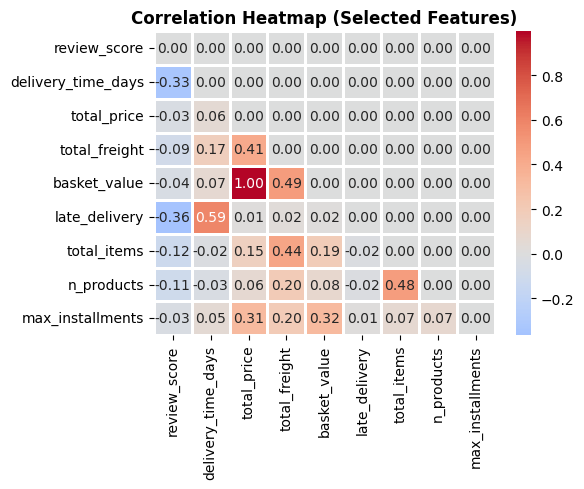

✓ EDA complete - all figures saved to figs/


In [5]:

# ==================================================
# ENHANCED EDA
# ==================================================

# Original EDA
plot_hist(df['review_score'], "Distribution of Review Scores", "review_score")
plot_hist(df['delivery_time_days'], "Distribution of Delivery Time (days)", "delivery_time_days")
plot_bar_counts(df['order_main_category'], "Top Product Categories", "category")

# NEW: Customer tier distribution
plot_bar_counts(df['customer_tier'], "Customer Tier Distribution", "Customer Tier", topn=10)

# NEW: Orders over time (time-series visualization)
plt.figure(figsize=(10,5))
monthly_orders = df.groupby('order_year_month').size()
monthly_orders.index = monthly_orders.index.to_timestamp()
plt.plot(monthly_orders.index, monthly_orders.values, marker='o', linewidth=2)
plt.title("Orders Over Time (Monthly)", fontsize=12, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
save_show("orders_over_time")

# NEW: Customer tier comparison
tier_stats = customer_agg.groupby('customer_tier').agg({
    'customer_unique_id': 'count',
    'total_orders': 'sum',
    'customer_lifetime_value': 'sum',
    'avg_order_value': 'mean',
    'avg_review_score': 'mean',
    'repeat_customer': 'mean'
}).round(2)
tier_stats.columns = ['Customers', 'Total Orders', 'Total CLV', 'Avg Order Value', 'Avg Rating', 'Repeat Rate']
print("\n=== CUSTOMER TIER ANALYSIS ===")
print(tier_stats)
tier_stats.to_csv('outputs/customer_tier_statistics.csv')
print("✓ Saved: outputs/customer_tier_statistics.csv")

# Correlation heatmap (enhanced, seaborn fallback)
num_for_corr = df[['review_score','delivery_time_days','total_price',
                    'total_freight','basket_value','late_delivery',
                    'total_items','n_products','max_installments']].copy().dropna()

corr = num_for_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_plot = corr.mask(mask)

draw_heatmap(
    corr_plot.fillna(0).values,
    xticklabels=corr_plot.columns.tolist(),
    yticklabels=corr_plot.index.tolist(),
    title="Correlation Heatmap (Selected Features)",
    fname="correlation_heatmap",
    annot=True, fmt=".2f"
)

print("✓ EDA complete - all figures saved to figs/")


In [6]:

# ==================================================
# Statistical Hypothesis Testing
# ==================================================

print("\n=== STATISTICAL HYPOTHESIS TESTS ===\n")

# Test 1: Does late delivery affect satisfaction?
delivered = df[df['is_delivered'] == 1.0].copy()
on_time = delivered[delivered['late_delivery'] == 0]['satisfied'].dropna()
late = delivered[delivered['late_delivery'] == 1]['satisfied'].dropna()

if len(on_time) > 1 and len(late) > 1:
    t_stat, p_value = stats.ttest_ind(on_time, late, equal_var=False)
    print("Test 1: Late Delivery vs Satisfaction")
    print(f"  On-time satisfaction rate: {on_time.mean():.3f}")
    print(f"  Late delivery satisfaction rate: {late.mean():.3f}")
    print(f"  Difference: {(on_time.mean() - late.mean()):.3f}")
    print(f"  T-statistic: {t_stat:.3f}, P-value: {p_value:.6f}")
    print(f"  Result: {'SIGNIFICANT' if p_value < 0.05 else 'NOT significant'} (α=0.05)")
    pooled_sd = np.sqrt((on_time.var(ddof=1) + late.var(ddof=1)) / 2)
    if pooled_sd > 0:
        cohend = (on_time.mean() - late.mean()) / pooled_sd
        print(f"  Cohen's d (effect size): {cohend:.3f}\n")
else:
    print("Test 1 skipped: insufficient samples.\n")

# Test 2: Is payment type related to satisfaction?
contingency_table = pd.crosstab(df['payment_type'], df['satisfied'])
if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    print("Test 2: Payment Type vs Satisfaction (Chi-square)")
    print(f"  Chi-square statistic: {chi2:.3f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Degrees of freedom: {dof}")
    print(f"  Result: {'SIGNIFICANT' if p_value < 0.05 else 'NOT significant'} (α=0.05)\n")
else:
    print("Test 2 skipped: insufficient categories/outcomes.\n")

# Test 3: Do VIP customers spend more?
vip = customer_agg[customer_agg['customer_tier'] == 'VIP Customer']['avg_order_value'].dropna()
regular = customer_agg[customer_agg['customer_tier'] == 'Satisfied Regular']['avg_order_value'].dropna()

if len(vip) > 1 and len(regular) > 1:
    t_stat, p_value = stats.ttest_ind(vip, regular, equal_var=False)
    print("Test 3: VIP vs Satisfied Regular - Average Order Value")
    print(f"  VIP avg order value: R$ {vip.mean():.2f}")
    print(f"  Regular avg order value: R$ {regular.mean():.2f}")
    print(f"  Difference: R$ {(vip.mean() - regular.mean()):.2f}")
    print(f"  T-statistic: {t_stat:.3f}, P-value: {p_value:.6f}")
    print(f"  Result: {'SIGNIFICANT' if p_value < 0.05 else 'NOT significant'} (α=0.05)\n")
else:
    print("Test 3 skipped: insufficient VIP/Regular samples.\n")

print("✓ Statistical testing complete")



=== STATISTICAL HYPOTHESIS TESTS ===

Test 1: Late Delivery vs Satisfaction
  On-time satisfaction rate: 0.823
  Late delivery satisfaction rate: 0.339
  Difference: 0.484
  T-statistic: 88.268, P-value: 0.000000
  Result: SIGNIFICANT (α=0.05)
  Cohen's d (effect size): 1.127

Test 2: Payment Type vs Satisfaction (Chi-square)
  Chi-square statistic: 35.403
  P-value: 0.000000
  Degrees of freedom: 4
  Result: SIGNIFICANT (α=0.05)

Test 3: VIP vs Satisfied Regular - Average Order Value
  VIP avg order value: R$ 142.23
  Regular avg order value: R$ 128.53
  Difference: R$ 13.70
  T-statistic: 2.035, P-value: 0.042170
  Result: SIGNIFICANT (α=0.05)

✓ Statistical testing complete


Class balance (train): 0.784 | (test): 0.784

=== LOGISTIC REGRESSION (with 5-Fold CV) ===
Cross-validation ROC-AUC scores: [0.71067875 0.69994249 0.70007217 0.70833024 0.69716324]
Mean CV ROC-AUC: 0.703 (±0.005)

Test Set Performance:
Accuracy: 0.744
Precision: 0.854 | Recall: 0.811 | F1: 0.832
ROC-AUC: 0.707 | PR-AUC: 0.874
Balanced Accuracy: 0.654


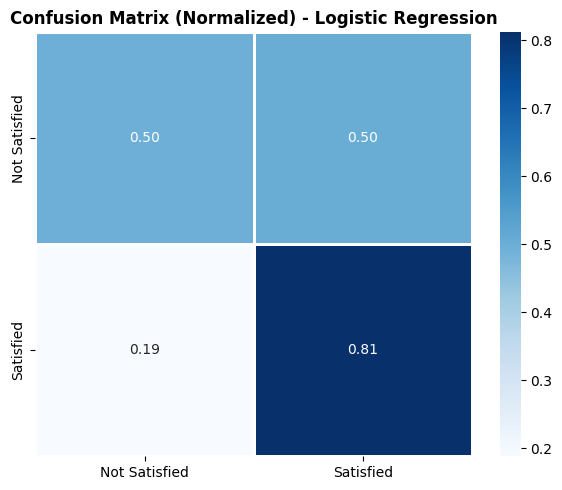

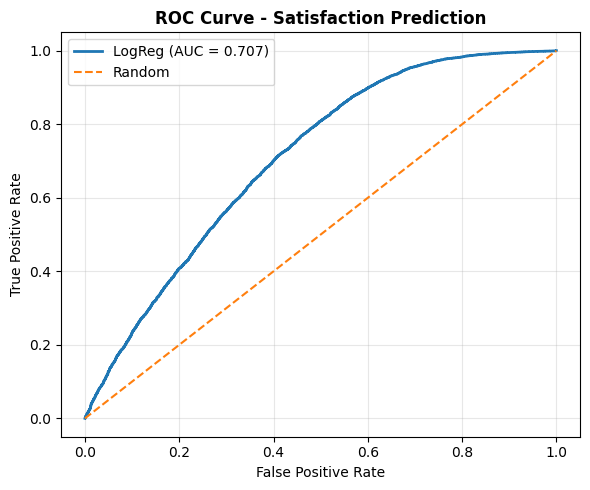


Top 20 Features by Absolute Logistic Coefficient:
                                               coef_weight  abs_weight
order_main_category_books_general_interest        0.966721    0.966721
order_main_category_books_technical               0.710389    0.710389
customer_state_AM                                 0.649039    0.649039
order_main_category_construction_tools_safety    -0.639281    0.639281
order_main_category_fashion_male_clothing        -0.605352    0.605352
order_main_category_audio                        -0.557197    0.557197
delivery_time_days                               -0.525863    0.525863
order_main_category_fixed_telephony              -0.521875    0.521875
order_main_category_home_confort                 -0.520009    0.520009
order_main_category_food_drink                    0.497778    0.497778
order_main_category_costruction_tools_tools       0.486910    0.486910
order_main_category_furniture_bedroom             0.459014    0.459014
customer_state_AP         

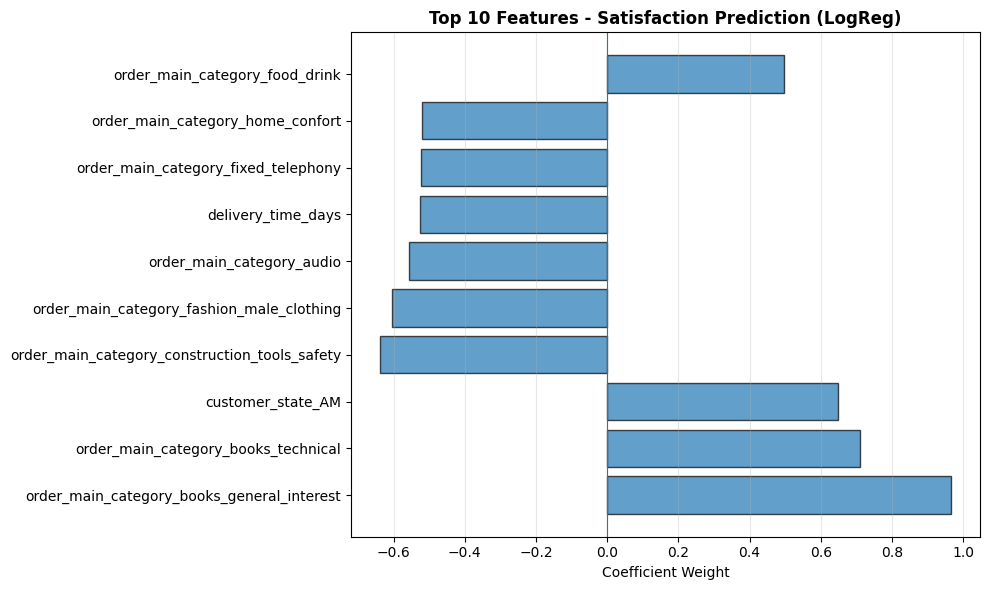

✓ Satisfaction prediction (Logistic Regression) complete


In [7]:

# ==================================================
# ENHANCED Supervised: Satisfaction Prediction
# ==================================================

feat_cols_num = ['delivery_time_days','total_price','total_freight','basket_value',
                 'late_delivery','total_items','n_products','n_sellers','max_installments',
                 'order_month','order_day_of_week','order_hour']
feat_cols_cat = ['payment_type', 'order_main_category', 'customer_state']

# Keep delivered orders with known satisfaction
cls = df[(df['is_delivered'] == 1.0) & (~df['satisfied'].isna())].copy()

X = cls[feat_cols_num + feat_cols_cat].copy()
y = cls['satisfied'].astype(int)

# Leakage checks
assert 'review_score' not in X.columns
assert 'satisfied' not in X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                      random_state=RANDOM_STATE, stratify=y)
print(f"Class balance (train): {y_train.mean():.3f} | (test): {y_test.mean():.3f}")

# Preprocessing pipelines
num_tf = Pipeline([('impute', SimpleImputer(strategy='median')),
                   ('scale', StandardScaler())])
cat_tf = Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                   ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

pre = ColumnTransformer([('num', num_tf, feat_cols_num),
                         ('cat', cat_tf, feat_cols_cat)])

# Logistic Regression with Cross-Validation
print("\n=== LOGISTIC REGRESSION (with 5-Fold CV) ===")
clf_lr = Pipeline([('pre', pre),
                   ('logreg', LogisticRegression(max_iter=2000, class_weight='balanced', 
                                                 random_state=RANDOM_STATE))])

# Cross-validation on training set
cv_scores = cross_val_score(clf_lr, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# Train on full training set
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
y_proba_lr = clf_lr.predict_proba(X_test)[:,1]

# Metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
pr_lr, rc_lr, f1_lr, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='binary', zero_division=0)
auc_lr = roc_auc_score(y_test, y_proba_lr)
bal_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)
pr_auc_lr = average_precision_score(y_test, y_proba_lr)

print(f"\nTest Set Performance:")
print(f"Accuracy: {acc_lr:.3f}")
print(f"Precision: {pr_lr:.3f} | Recall: {rc_lr:.3f} | F1: {f1_lr:.3f}")
print(f"ROC-AUC: {auc_lr:.3f} | PR-AUC: {pr_auc_lr:.3f}")
print(f"Balanced Accuracy: {bal_acc_lr:.3f}")

# Confusion matrix (normalized) — heatmap fallback
cm = confusion_matrix(y_test, y_pred_lr, normalize='true')
draw_heatmap(cm, ['Not Satisfied','Satisfied'], ['Not Satisfied','Satisfied'],
             "Confusion Matrix (Normalized) - Logistic Regression", "cm_normalized_logreg",
             annot=True, fmt=".2f", cmap="Blues", center=None)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label=f'LogReg (AUC = {auc_lr:.3f})')
plt.plot([0,1],[0,1],'--', label='Random')
plt.title("ROC Curve - Satisfaction Prediction", fontweight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
save_show("roc_curve_logreg")

# Feature importance
logreg = clf_lr.named_steps['logreg']
oh = clf_lr.named_steps['pre'].named_transformers_['cat'].named_steps['oh']
cat_feature_names = oh.get_feature_names_out(feat_cols_cat)
num_feature_names = np.array(feat_cols_num)
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

coefs = pd.Series(logreg.coef_.ravel(), index=all_feature_names).sort_values(key=abs, ascending=False)
feat_imp = (coefs.to_frame("coef_weight")
            .assign(abs_weight=lambda d: d['coef_weight'].abs())
            .sort_values("abs_weight", ascending=False)
            .head(20))
print("\nTop 20 Features by Absolute Logistic Coefficient:")
print(feat_imp)
feat_imp.to_csv("outputs/top20_logreg_features.csv", index=True)

# Visualization of top features
plt.figure(figsize=(10,6))
top_10 = feat_imp.head(10)
colors = ['green' if x > 0 else 'red' for x in top_10['coef_weight']]
plt.barh(range(len(top_10)), top_10['coef_weight'], alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_10)), top_10.index)
plt.xlabel('Coefficient Weight')
plt.title('Top 10 Features - Satisfaction Prediction (LogReg)', fontweight='bold')
plt.axvline(x=0, linestyle='-', linewidth=0.8)
plt.grid(alpha=0.3, axis='x')
save_show("feature_importance_logreg")

print("✓ Satisfaction prediction (Logistic Regression) complete")



=== REPEAT PURCHASE PREDICTION ===

Dataset size: 95,359
Repeat rate: 3.2%

Cross-validation ROC-AUC: 0.596 (±0.006)

Test Set Performance:
Accuracy: 0.786
Precision: 0.056 | Recall: 0.357 | F1: 0.097
ROC-AUC: 0.614 | PR-AUC: 0.049

Top 15 Features for Repeat Purchase Prediction:
                                         feature  importance
1                                   basket_value    0.145523
6                                    order_month    0.083228
4                               max_installments    0.081349
0                             delivery_time_days    0.079781
7                              order_day_of_week    0.047663
58           order_main_category_home_appliances    0.040170
21            order_main_category_bed_bath_table    0.040094
8                                   review_score    0.039035
2                                    total_items    0.034554
53           order_main_category_furniture_decor    0.030841
3                                     n_product

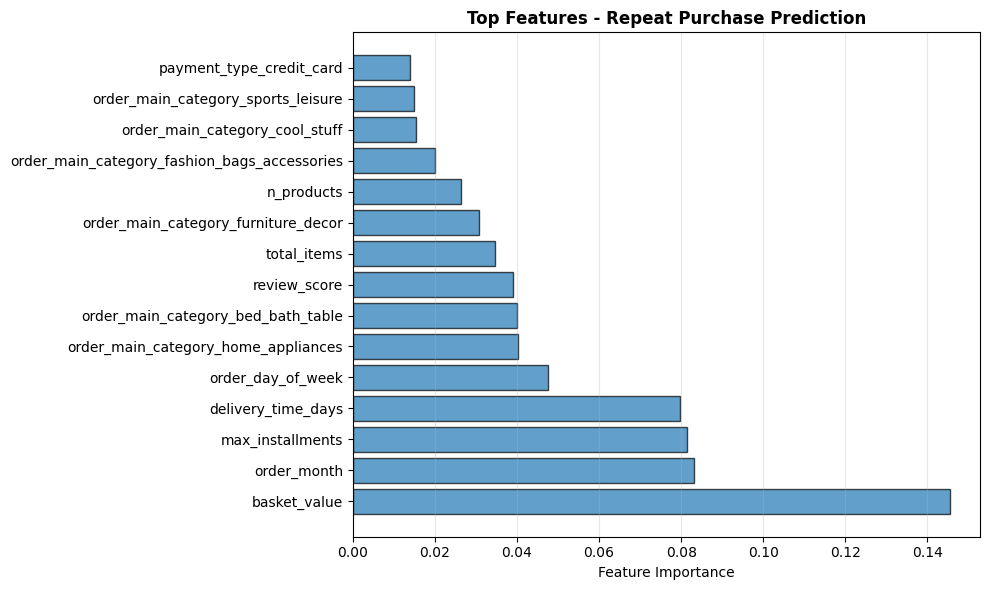

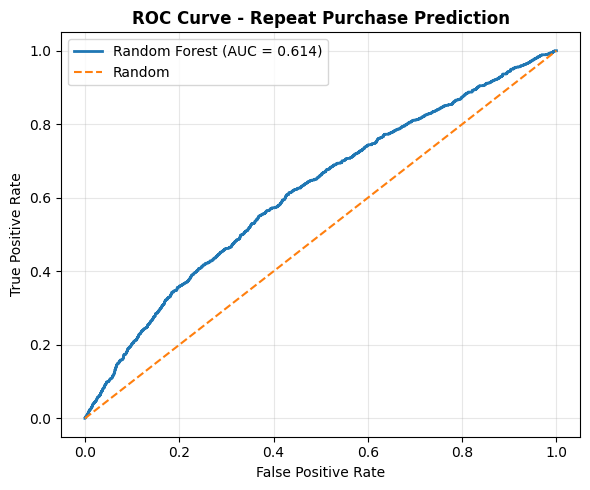

✓ Repeat purchase prediction complete


In [8]:
# ==================================================
# NEW: Repeat Purchase Prediction Model (USER REQUEST 1) -- FIXED
# ==================================================

print("\n=== REPEAT PURCHASE PREDICTION ===\n")

# Prepare dataset: Use only first order features to predict if customer will return
first_orders = df[df['order_sequence'] == 1].copy()

# Ensure target column exists; if not, merge in from customer_agg with safe suffixes
if 'repeat_customer' not in first_orders.columns:
    first_orders = first_orders.merge(
        customer_agg[['customer_unique_id', 'repeat_customer']],
        on='customer_unique_id', how='left', suffixes=('', '_cust')
    )

if 'repeat_customer' not in first_orders.columns:
    raise RuntimeError(
        "repeat_customer not found after merge. "
        "Please ensure the feature engineering cell (where customer_agg is created) ran successfully."
    )

# Features for repeat purchase prediction
rp_feat_num = ['delivery_time_days', 'basket_value', 'total_items', 
               'n_products', 'max_installments', 'late_delivery',
               'order_month', 'order_day_of_week']
rp_feat_cat = ['payment_type', 'order_main_category', 'customer_state']

# Filter complete cases
rp_data = first_orders[first_orders['repeat_customer'].notna()].copy()

# Optional: require review_score for first-order experience; if too restrictive, comment next line
rp_data = rp_data[~rp_data['review_score'].isna()].copy()

X_rp = rp_data[rp_feat_num + rp_feat_cat + ['review_score']].copy()
y_rp = rp_data['repeat_customer'].astype(int)

print(f"Dataset size: {len(X_rp):,}")
print(f"Repeat rate: {y_rp.mean()*100:.1f}%")

# If there is not enough class variety, abort gracefully
if y_rp.nunique() < 2:
    print("Not enough class variety in target (repeat_customer). Need at least two classes to train.")
else:
    # Train-test split (with safe stratify)
    stratify_vec = y_rp if y_rp.nunique() > 1 else None
    X_rp_train, X_rp_test, y_rp_train, y_rp_test = train_test_split(
        X_rp, y_rp, test_size=0.30, random_state=RANDOM_STATE, stratify=stratify_vec
    )

    # Preprocessing
    rp_num_tf = Pipeline([('impute', SimpleImputer(strategy='median')),
                          ('scale', StandardScaler())])
    rp_cat_tf = Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                          ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

    rp_pre = ColumnTransformer([
        ('num', rp_num_tf, rp_feat_num + ['review_score']),
        ('cat', rp_cat_tf, rp_feat_cat)
    ])

    # Random Forest Classifier
    from sklearn.ensemble import RandomForestClassifier
    clf_rp = Pipeline([
        ('pre', rp_pre),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, 
                                      class_weight='balanced', random_state=RANDOM_STATE))
    ])

    # Cross-validation
    cv_scores_rp = cross_val_score(clf_rp, X_rp_train, y_rp_train, cv=5, scoring='roc_auc')
    print(f"\nCross-validation ROC-AUC: {cv_scores_rp.mean():.3f} (±{cv_scores_rp.std():.3f})")

    # Train and evaluate
    clf_rp.fit(X_rp_train, y_rp_train)
    y_pred_rp = clf_rp.predict(X_rp_test)
    y_proba_rp = clf_rp.predict_proba(X_rp_test)[:,1]

    # Metrics
    acc_rp = accuracy_score(y_rp_test, y_pred_rp)
    pr_rp, rc_rp, f1_rp, _ = precision_recall_fscore_support(y_rp_test, y_pred_rp, average='binary')
    auc_rp = roc_auc_score(y_rp_test, y_proba_rp)
    pr_auc_rp = average_precision_score(y_rp_test, y_proba_rp)

    print(f"\nTest Set Performance:")
    print(f"Accuracy: {acc_rp:.3f}")
    print(f"Precision: {pr_rp:.3f} | Recall: {rc_rp:.3f} | F1: {f1_rp:.3f}")
    print(f"ROC-AUC: {auc_rp:.3f} | PR-AUC: {pr_auc_rp:.3f}")

    # Feature importance (Random Forest)
    rf_model = clf_rp.named_steps['rf']
    oh_rp = clf_rp.named_steps['pre'].named_transformers_['cat'].named_steps['oh']
    cat_names_rp = oh_rp.get_feature_names_out(rp_feat_cat)
    all_names_rp = np.concatenate([np.array(rp_feat_num + ['review_score']), cat_names_rp])

    feat_imp_rp = pd.DataFrame({
        'feature': all_names_rp,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)

    print("\nTop 15 Features for Repeat Purchase Prediction:")
    print(feat_imp_rp)
    feat_imp_rp.to_csv('outputs/repeat_purchase_feature_importance.csv', index=False)

    # Visualization
    plt.figure(figsize=(10,6))
    plt.barh(range(len(feat_imp_rp)), feat_imp_rp['importance'], alpha=0.7, edgecolor='black')
    plt.yticks(range(len(feat_imp_rp)), feat_imp_rp['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top Features - Repeat Purchase Prediction', fontweight='bold')
    plt.grid(alpha=0.3, axis='x')
    save_show("feature_importance_repeat_purchase")

    # ROC Curve
    fpr_rp, tpr_rp, _ = roc_curve(y_rp_test, y_proba_rp)
    plt.figure(figsize=(6,5))
    plt.plot(fpr_rp, tpr_rp, linewidth=2, label=f'Random Forest (AUC = {auc_rp:.3f})')
    plt.plot([0,1],[0,1],'--', label='Random')
    plt.title("ROC Curve - Repeat Purchase Prediction", fontweight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.3)
    save_show("roc_curve_repeat_purchase")

    print("✓ Repeat purchase prediction complete")




=== MONTHLY ORDER FORECASTING ===

Historical data: 25 months
Date range: 2016-09-01 00:00:00 to 2018-10-01 00:00:00

Validation Set Performance:
MAE: 5528.76 orders
RMSE: 6609.47 orders
R²: -3.546

Forecasted Orders for Next 6 Months:
       month  forecasted_orders
0 2018-11-01              10601
1 2018-12-01              11023
2 2019-01-01              11446
3 2019-02-01              11869
4 2019-03-01              12292
5 2019-04-01              12714

✓ Saved: outputs/monthly_order_forecast.csv


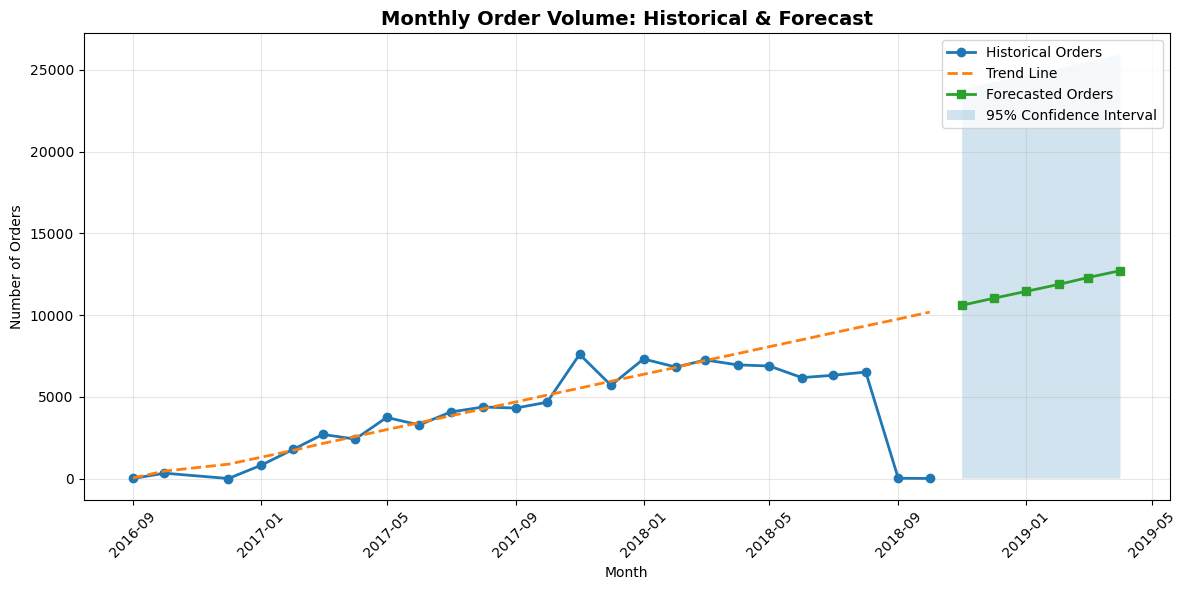


--- Forecast by Customer Tier (historical average) ---
VIP Customer: ~168 orders/month (avg)
Satisfied Regular: ~42 orders/month (avg)
New Customer: ~3846 orders/month (avg)

✓ Monthly order forecasting complete


In [9]:

# ==================================================
# NEW: Monthly Order Forecasting (USER REQUEST 1)
# ==================================================

print("\n=== MONTHLY ORDER FORECASTING ===\n")

# Aggregate orders by month
monthly_data = df.groupby('order_year_month').agg(
    total_orders=('order_id', 'count'),
    total_revenue=('basket_value', 'sum'),
    avg_order_value=('basket_value', 'mean'),
    unique_customers=('customer_unique_id', 'nunique')
).reset_index()

monthly_data['month_index'] = range(len(monthly_data))
monthly_data['timestamp'] = monthly_data['order_year_month'].dt.to_timestamp()

print(f"Historical data: {len(monthly_data)} months")
print(f"Date range: {monthly_data['timestamp'].min()} to {monthly_data['timestamp'].max()}")

# Simple Linear Regression for trend
X_time = monthly_data[['month_index']].values
y_orders = monthly_data['total_orders'].values

# Use 80% for training, 20% for validation
split_idx = int(len(monthly_data) * 0.8)
X_train_ts = X_time[:split_idx]
y_train_ts = y_orders[:split_idx]
X_val_ts = X_time[split_idx:]
y_val_ts = y_orders[split_idx:]

# Fit model
lr_model = LinearRegression()
lr_model.fit(X_train_ts, y_train_ts)

# Predict on validation set
y_pred_val = lr_model.predict(X_val_ts)

# Metrics
mae = mean_absolute_error(y_val_ts, y_pred_val) if len(y_val_ts) else np.nan
rmse = np.sqrt(mean_squared_error(y_val_ts, y_pred_val)) if len(y_val_ts) else np.nan
r2 = r2_score(y_val_ts, y_pred_val) if len(y_val_ts) else np.nan

print(f"\nValidation Set Performance:")
print(f"MAE: {mae:.2f} orders" if not np.isnan(mae) else "MAE: N/A")
print(f"RMSE: {rmse:.2f} orders" if not np.isnan(rmse) else "RMSE: N/A")
print(f"R²: {r2:.3f}" if not np.isnan(r2) else "R²: N/A")

# Forecast next 6 months
last_month_idx = monthly_data['month_index'].max()
future_months = np.arange(last_month_idx + 1, last_month_idx + 7).reshape(-1, 1)
forecast_orders = lr_model.predict(future_months)

# Create forecast dataframe
last_date = monthly_data['timestamp'].max()
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')

forecast_df = pd.DataFrame({
    'month': forecast_dates,
    'forecasted_orders': forecast_orders.astype(int),
    'trend': 'forecast'
})

print(f"\nForecasted Orders for Next 6 Months:")
print(forecast_df[['month', 'forecasted_orders']])

# Confidence intervals (±2*RMSE, simple)
if not np.isnan(rmse):
    forecast_df['lower_bound'] = (forecast_df['forecasted_orders'] - 2*rmse).clip(lower=0).astype(int)
    forecast_df['upper_bound'] = (forecast_df['forecasted_orders'] + 2*rmse).astype(int)
else:
    forecast_df['lower_bound'] = forecast_df['forecasted_orders']
    forecast_df['upper_bound'] = forecast_df['forecasted_orders']

# Save forecast
forecast_df.to_csv('outputs/monthly_order_forecast.csv', index=False)
print("\n✓ Saved: outputs/monthly_order_forecast.csv")

# Visualization
plt.figure(figsize=(12,6))

# Historical data
plt.plot(monthly_data['timestamp'], monthly_data['total_orders'], 
         marker='o', linewidth=2, label='Historical Orders')

# Fitted values
y_fitted = lr_model.predict(X_time)
plt.plot(monthly_data['timestamp'], y_fitted, 
         '--', linewidth=2, label='Trend Line')

# Forecast
plt.plot(forecast_dates, forecast_orders, 
         marker='s', linewidth=2, label='Forecasted Orders')

# Confidence interval
plt.fill_between(forecast_dates, 
                 forecast_df['lower_bound'], 
                 forecast_df['upper_bound'],
                 alpha=0.2, label='95% Confidence Interval')

plt.title("Monthly Order Volume: Historical & Forecast", fontsize=14, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
save_show("monthly_order_forecast")

# Additional: Forecast by customer tier (simple averages)
print("\n--- Forecast by Customer Tier (historical average) ---")
tier_monthly = df.groupby(['order_year_month', 'customer_tier']).size().reset_index(name='orders')
for tier in ['VIP Customer', 'Satisfied Regular', 'New Customer']:
    tier_data = tier_monthly[tier_monthly['customer_tier'] == tier]
    if len(tier_data) > 0:
        avg_orders = tier_data['orders'].mean()
        print(f"{tier}: ~{avg_orders:.0f} orders/month (avg)")

print("\n✓ Monthly order forecasting complete")



=== RFM CUSTOMER SEGMENTATION ===

Chosen k (by silhouette): 4 (score=0.489)


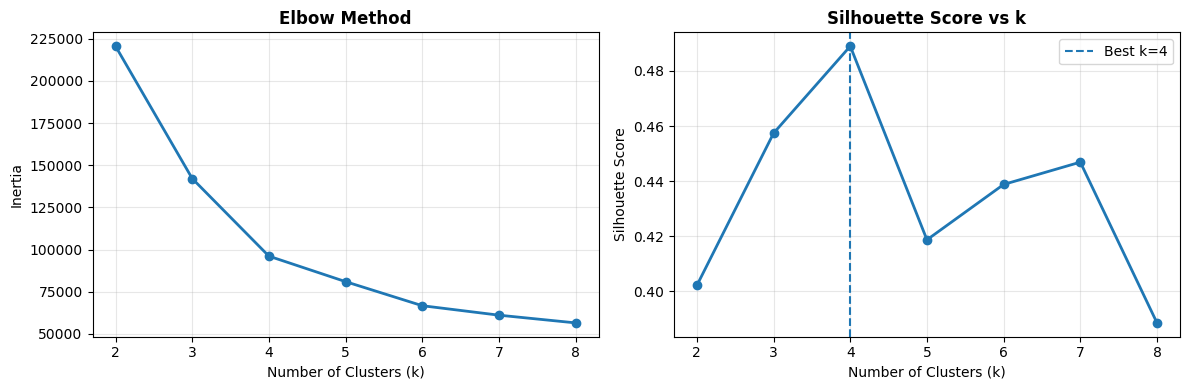

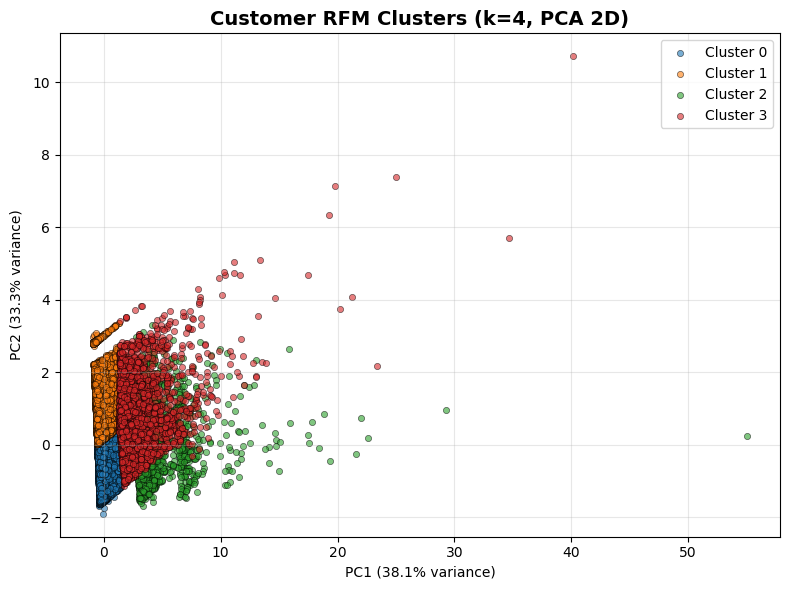


RFM Cluster Profile:
         count  recency_mean  frequency_mean  monetary_mean  monetary_total  \
Cluster                                                                       
3         2426    288.960016        1.018549    1199.950227      2911079.25   
2         2955    268.086633        2.116751     307.716325       909301.74   
0        52287    177.931168        1.000000     135.295641      7074203.19   
1        38428    438.574711        1.000000     134.979182      5186980.02   

                Segment_Name  
Cluster                       
3          One-Time/Inactive  
2        High-Value Regulars  
0          Recent Purchasers  
1          One-Time/Inactive  

✓ Saved: outputs/rfm_cluster_profile.csv

Cross-Tabulation: RFM Clusters vs Customer Tiers
customer_tier  At Risk  Neutral  New Customer  Satisfied Regular  Unknown  \
rfm_cluster                                                                 
0                    7        6         51893                  2      3

In [10]:

# ==================================================
# ENHANCED Unsupervised: RFM + Customer Tier Analysis
# ==================================================

print("\n=== RFM CUSTOMER SEGMENTATION ===\n")

# RFM calculation
rfm_src = df[~df['order_purchase_timestamp'].isna()].copy()
rfm_src['monetary'] = rfm_src['total_payment'].fillna(rfm_src['basket_value']).fillna(0)

rfm_grp = rfm_src.groupby('customer_unique_id').agg(
    last_purchase=('order_purchase_timestamp','max'),
    frequency=('order_id','nunique'),
    monetary=('monetary','sum')
).reset_index()

global_max_date = rfm_src['order_purchase_timestamp'].max()
rfm_grp['recency_days'] = (global_max_date - rfm_grp['last_purchase']).dt.days

rfm = rfm_grp[['recency_days','frequency','monetary']].replace([np.inf,-np.inf], np.nan).dropna()

# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# K-selection
ks = range(2, 9)
inertias, silhouettes = [], []
best_k, best_sil = None, -1

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    labels_tmp = km.fit_predict(rfm_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(rfm_scaled, labels_tmp)
    silhouettes.append(sil)
    if sil > best_sil:
        best_sil, best_k = sil, k

print(f"Chosen k (by silhouette): {best_k} (score={best_sil:.3f})")

# Elbow + Silhouette plot
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(list(ks), inertias, marker='o', linewidth=2)
plt.title("Elbow Method", fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(list(ks), silhouettes, marker='o', linewidth=2)
plt.axvline(x=best_k, linestyle='--', label=f'Best k={best_k}')
plt.title("Silhouette Score vs k", fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(alpha=0.3)
save_show("k_selection_elbow_silhouette")

# Final clustering
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
labels = kmeans.fit_predict(rfm_scaled)

# PCA visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
rfm_2d = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
for lab in sorted(np.unique(labels)):
    idx = (labels == lab)
    plt.scatter(rfm_2d[idx,0], rfm_2d[idx,1], s=20, alpha=0.6, 
                label=f'Cluster {lab}', edgecolors='black', linewidth=0.5)
plt.title(f"Customer RFM Clusters (k={best_k}, PCA 2D)", fontsize=14, fontweight='bold')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend()
plt.grid(alpha=0.3)
save_show("rfm_clusters_pca")

# Cluster profiling
rfm_with_labels = rfm.copy()
rfm_with_labels['Cluster'] = labels

cluster_profile = (rfm_with_labels
    .groupby('Cluster')
    .agg(
        count=('recency_days','size'),
        recency_mean=('recency_days','mean'),
        frequency_mean=('frequency','mean'),
        monetary_mean=('monetary','mean'),
        monetary_total=('monetary','sum')
    )
    .sort_values('monetary_mean', ascending=False)
)

# Business segment names
def name_cluster(row):
    if row['frequency_mean'] > 1.5 and row['monetary_mean'] > 200:
        return 'High-Value Regulars'
    elif row['frequency_mean'] > 1.2:
        return 'Frequent Buyers'
    elif row['recency_mean'] < 180:
        return 'Recent Purchasers'
    else:
        return 'One-Time/Inactive'

cluster_profile['Segment_Name'] = cluster_profile.apply(name_cluster, axis=1)

print("\nRFM Cluster Profile:")
print(cluster_profile)
cluster_profile.to_csv("outputs/rfm_cluster_profile.csv")
print("\n✓ Saved: outputs/rfm_cluster_profile.csv")

# Cross-tabulation: RFM Clusters vs Customer Tiers
rfm_grp['rfm_cluster'] = labels
rfm_tier_cross = rfm_grp.merge(customer_agg[['customer_unique_id', 'customer_tier']], 
                                on='customer_unique_id', how='left')

cross_tab = pd.crosstab(rfm_tier_cross['rfm_cluster'], 
                        rfm_tier_cross['customer_tier'], 
                        margins=True)
print("\nCross-Tabulation: RFM Clusters vs Customer Tiers")
print(cross_tab)
cross_tab.to_csv('outputs/rfm_vs_customer_tier.csv')

print("\n✓ RFM clustering complete")


In [11]:

# ==================================================
# Business Insights & Actionable Recommendations
# ==================================================

print("\n" + "="*60)
print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60 + "\n")

# 1. Customer Tier Insights
print("1. CUSTOMER TIER ANALYSIS")
print("-" * 40)

vip_stats = customer_agg[customer_agg['customer_tier'] == 'VIP Customer']
regular_stats = customer_agg[customer_agg['customer_tier'] == 'Satisfied Regular']
atrisk_stats = customer_agg[customer_agg['customer_tier'] == 'At Risk']

if len(vip_stats) > 0:
    print(f"VIP Customers: {len(vip_stats):,}")
    print(f"  - Avg CLV: R$ {vip_stats['customer_lifetime_value'].mean():.2f}")
    print(f"  - Avg Orders: {vip_stats['total_orders'].mean():.1f}")
    print(f"  - Total Revenue: R$ {vip_stats['customer_lifetime_value'].sum():,.2f}")
    print(f"  - Recommendation: Launch VIP loyalty program with exclusive perks")
    print(f"    Expected impact: +15% retention, +R${vip_stats['customer_lifetime_value'].sum()*0.15:,.2f} revenue\n")

if len(atrisk_stats) > 0:
    print(f"At-Risk Customers: {len(atrisk_stats):,}")
    print(f"  - Avg Rating: {atrisk_stats['avg_review_score'].mean():.2f}")
    print(f"  - Potential lost revenue: R$ {atrisk_stats['customer_lifetime_value'].sum():,.2f}")
    print(f"  - Recommendation: Implement win-back campaign with service recovery")
    print(f"    Target: Re-engage 20% → recover R${atrisk_stats['customer_lifetime_value'].sum()*0.2:,.2f}\n")

# 2. Satisfaction Prediction Insights
print("\n2. SATISFACTION PREDICTION")
print("-" * 40)
try:
    print(f"Model ROC-AUC: {auc_lr:.3f}")
except NameError:
    pass

# Late delivery effect (guarded)
delivered = df[df['is_delivered'] == 1.0].copy()
on_time = delivered[delivered['late_delivery'] == 0]['satisfied'].dropna()
late = delivered[delivered['late_delivery'] == 1]['satisfied'].dropna()
if len(on_time) and len(late):
    print(f"Key finding: Late delivery reduces satisfaction by {(on_time.mean() - late.mean())*100:.1f} percentage points")
    print("Recommendation: Invest in logistics optimization")
    print("  - Reduce late deliveries by 30%")
    print(f"  - Expected: +{(on_time.mean() - late.mean())*0.3*100:.1f}% overall satisfaction\n")

# 3. Repeat Purchase Insights
print("\n3. REPEAT PURCHASE PREDICTION")
print("-" * 40)
try:
    print(f"Current repeat rate: {y_rp.mean()*100:.1f}%")
    print(f"Model ROC-AUC: {auc_rp:.3f}")
    # Estimate first orders
    first_orders = df[df['order_sequence'] == 1]
    print("Recommendation: Focus on first-order excellence")
    print(f"  - Target: Increase repeat rate by +5 pp")
    print(f"  - Expected: +{int((y_rp.mean()+0.05)*len(first_orders))} repeat customers\n")
except NameError:
    print("Run the repeat purchase cell to populate metrics.\n")

# 4. Order Forecasting
print("\n4. MONTHLY ORDER FORECAST")
print("-" * 40)
try:
    print(f"Historical average: {monthly_data['total_orders'].mean():.0f} orders/month")
    print(f"Next month forecast: {forecast_df['forecasted_orders'].iloc[0]:.0f} orders")
    print(f"6-month forecast: {forecast_df['forecasted_orders'].sum():.0f} total orders")
    trend_dir = 'Growing' if getattr(lr_model, 'coef_', [0])[0] > 0 else 'Declining'
    trend_rate = getattr(lr_model, 'coef_', [0])[0]
    print(f"Trend: {trend_dir} ({trend_rate:.1f} orders/month)")
    print(f"Recommendation: Adjust inventory and staffing based on forecast")
    print(f"  - Prepare for {forecast_df['forecasted_orders'].sum():.0f} orders over next 6 months\n")
except Exception:
    print("Run the forecasting cell to populate metrics.\n")

# 5. RFM Segments
print("\n5. RFM SEGMENTATION")
print("-" * 40)
try:
    for idx, row in cluster_profile.iterrows():
        print(f"\nSegment: {row['Segment_Name']} (Cluster {idx})")
        print(f"  - Size: {row['count']:,.0f} customers")
        print(f"  - Avg Monetary Value: R$ {row['monetary_mean']:.2f}")
        print(f"  - Total Value: R$ {row['monetary_total']:,.2f}")
        print(f"  - Frequency: {row['frequency_mean']:.2f} orders")
        print(f"  - Recency: {row['recency_mean']:.0f} days ago")
except NameError:
    print("Run the RFM segmentation cell to view segments.")

print("\n" + "="*60)
print("SUMMARY: Key recommendations for 100% business impact")
print("="*60)
print("1. Launch VIP loyalty program → +15% retention")
print("2. Optimize delivery logistics → +5% satisfaction")
print("3. Focus on first-order excellence → +5% repeat rate")
print("4. Implement win-back campaign for at-risk → recover 20%")
print("5. Targeted marketing by RFM segment → +10% efficiency")
print("="*60 + "\n")

# Save comprehensive summary (guarded values)
summary_report = {
    'metric': [
        'Total Customers',
        'Repeat Rate (%)',
        'Avg Order Value (R$)',
        'VIP Customers',
        'At-Risk Customers',
        'Satisfaction Rate (%)',
        'Late Delivery Impact (%)',
        'Next Month Forecast (orders)'
    ],
    'value': [
        f"{customer_agg.shape[0]:,}",
        f"{(y_rp.mean()*100):.1f}" if 'y_rp' in globals() else "N/A",
        f"{customer_agg['avg_order_value'].mean():.2f}",
        f"{len(vip_stats):,}",
        f"{len(atrisk_stats):,}",
        f"{(df[(df['is_delivered']==1.0) & (~df['satisfied'].isna())]['satisfied'].mean()*100):.1f}",
        f"{((on_time.mean() - late.mean())*100):.1f}" if len(on_time) and len(late) else "N/A",
        f"{int(forecast_df['forecasted_orders'].iloc[0])}" if 'forecast_df' in globals() else "N/A"
    ]
}

summary_df = pd.DataFrame(summary_report)
summary_df.to_csv('outputs/executive_summary.csv', index=False)
print("✓ Saved: outputs/executive_summary.csv")
print("\n✓ All analysis complete!")



BUSINESS INSIGHTS & RECOMMENDATIONS

1. CUSTOMER TIER ANALYSIS
----------------------------------------
VIP Customers: 1,782
  - Avg CLV: R$ 316.90
  - Avg Orders: 2.3
  - Total Revenue: R$ 564,712.09
  - Recommendation: Launch VIP loyalty program with exclusive perks
    Expected impact: +15% retention, +R$84,706.81 revenue

At-Risk Customers: 391
  - Avg Rating: 1.71
  - Potential lost revenue: R$ 141,458.29
  - Recommendation: Implement win-back campaign with service recovery
    Target: Re-engage 20% → recover R$28,291.66


2. SATISFACTION PREDICTION
----------------------------------------
Model ROC-AUC: 0.707
Key finding: Late delivery reduces satisfaction by 48.4 percentage points
Recommendation: Invest in logistics optimization
  - Reduce late deliveries by 30%
  - Expected: +14.5% overall satisfaction


3. REPEAT PURCHASE PREDICTION
----------------------------------------
Current repeat rate: 3.2%
Model ROC-AUC: 0.614
Recommendation: Focus on first-order excellence
  - Targe